<a href="https://colab.research.google.com/github/OrsonTyphanel93/Deep-Learning-Orson-/blob/master/Copie_de_adversarial_training_lab2_Orson_Typhanel_mengara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: adversarial training

Due date : February 25

Goals of the labs:
- Implement your first robust model
- Grab insights on what makes a model robust

Please note that some models can take a long time to train and be hard to debug. We have indicate the approximate runnig time of the corresponding cell. 

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:

# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## From adversarial examples to training robust models

In the previous lab, we focused on methods for solving the inner maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this lab we solve the min-max problem, which corresponds to the task of training a model that is robust to adversarial attacks. In other words, no matter what attack an adversary uses, we want to have a model that performs well.  That is, given some set of input/ouptput pairs $S$, we want to solve the outer minimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$ (this was implicitly assumed throughout the entire previous section), and that they get to specialize their attack to whatever parameters we have chosen in the outer maximization.  The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model. 

The good news, in some sense, is that we already did a lot of the hard work in adversarial training, when we described various ways to approximately solve the inner maximization problem.  

## Adversarial training with adversarial examples

Perhaps the simplest strategy for training an adversarially robust model is also the one which seems most intuitive.  The basic idea (which originally was referred to as "adversarial training" in the machine learning literature, though is also basic technique from robust optimization when viewed through this lense) is to simply create and then incorporate adversarial examples into the training process.  In other words, since we know that "standard" training creates networks that are succeptible to adversarial examples, let's just _also_ train on a few adversarial examples.

Of course, the question arises as to _which_ adversarial examples we should train on. 
Supposing we generally want to optimize the min-max objective 
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
using gradient descent, how do we do so?  If we want to simply optimize $\theta$ by stochastic gradient descent, this would simply involve computing repeatedly **computing** the gradient with respect to $\theta$ for the loss function on some minibatch, and taking a step in this negative direction.  That is, we want to repeat the update
\begin{equation}
\theta := \theta - \alpha \frac{1}{|B|} \sum_{x,y \in B} \nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

How do we go about computing this inner gradient? The answer is given by Danskin's Theorem, which states that to compute the (sub)gradient of a function containing a max term, we need to simply 1) find the maximum, and 2) compute the normal gradient evaluated at this point.  In other words, the relevant gradient is given by
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\nabla_\theta \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) = \nabla_\theta \ell(h_\theta(x + \delta^\star(x)), y)
\end{equation}
where 
\begin{equation}
\delta^\star(x) = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

As we learned from the previous section, finding the maximum exactly is not an easy task.  And it is very difficult to say anything formally about the nature of the gradient if we do not solve the problem optimally.  Nonetheless, what we find in practice is the following: the "quality" of the robust gradient descent procedure is tied directly to how well we are able to perform the maximization.  In other words, the better job we do of solving the inner maximization problem, better our estimation of the inner gradient is.  In other words, _the key aspects of adversarial training is incorporate a strong attack into the inner maximization procedure_.  And projected gradient descent approaches (again, this included the simple variants like projected steepest descent) are the strongest attack that the community has found.

To recap, our strategy is the following:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}
Although this procedure approximately optimizes the robust loss, which is exactly the target we would like to optimize, in practice it is common to _also_ include a bit of the standard loss (i.e., also take gradient steps in the original data points), as this tends to also slightly improve the performance of the "standard" error of the task.  It is also common to randomize over the starting positions for PGD, or else there can be issues with the procedure learning loss surface such that the gradients exactly at the same points point in a "shallow" direction, but very nearby there are points that have the more typical steep loss surfaces of deep networks.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(
      nn.Linear(784, 10)).to(device)

# Multiple ways of attacking

In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=5, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


## Question 1 Implement a robust training algorithm

Implement the following robust training algorithm in the function $\texttt{epoch_adversarial}$
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \mbox{1. Select minibatch $B$, initialize gradient vector $g := 0$} \\
& \quad \mbox{2. For each $(x,y)$ in $B$:} \\
& \quad \quad \mbox{a. Find an attack perturbation $\delta^\star$ by (approximately) optimizing } \\
& \qquad \qquad \qquad \delta^\star = \argmax_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y) \\
& \quad \quad \mbox{b. Add gradient at $\delta^\star$} \\
& \qquad \qquad \qquad g:= g + \nabla_\theta \ell(h_\theta(x + \delta^\star), y) \\
& \quad \mbox{3. Update parameters $\theta$} \\
& \qquad \qquad \qquad \theta:= \theta - \frac{\alpha}{|B|} g
\end{split}
\end{equation}

In [ ]:

def epoch_adversarial(loader, model, attack=pgd_linf, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Standard (i.e. non-robust) training on the logistic regression

In [ ]:
# This cell should run in less than 3 minutes
model_logreg = nn.Sequential(
     Flatten(),
     nn.Linear(784, 10)).to(device)
opt = optim.SGD(model_logreg.parameters(), lr=1e-1)
print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_logreg, opt)
    test_err, test_loss = epoch(test_loader, model_logreg)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_logreg, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err
0.133783	0.097300	0.389800
0.098800	0.090600	0.408700
0.092783	0.085800	0.432800
0.087400	0.084400	0.446500
0.085583	0.080500	0.469900
0.083017	0.081100	0.465200
0.082783	0.080900	0.466400
0.082817	0.080900	0.467100
0.082767	0.081200	0.471100
0.082650	0.080500	0.472700


## Question 2

What are the errors on the training set? The test set? The adversarial set? Comment.

answers:

*We find that the learning error is quite low (8.0%) and the contradiction error is quite high (47%), but the testing error is quite low (8.0%) and decreases as the model is learned. This is because adversarial learning makes the landscape of weight loss clearer in the logistic regression. So, learning error = testing error implies too high a contradictory error, thus an overlearning situation*

# Adversarial training on the logistic regression

In [ ]:
# This cell should run in less than 3 minutes
model_logreg_robust = nn.Sequential(
     Flatten(),
     nn.Linear(784, 10)).to(device)
opt = optim.SGD(model_logreg_robust.parameters(), lr=1e-1)
print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_logreg_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_logreg_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_logreg_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err
0.300333	0.116600	0.261000
0.259867	0.109200	0.253100
0.255850	0.110900	0.247600
0.253867	0.108600	0.246600
0.253283	0.109500	0.246000
0.246867	0.109000	0.242800
0.246967	0.108100	0.244300
0.246967	0.108400	0.243900
0.246717	0.108900	0.242400
0.246933	0.108800	0.243900


## Question 3  

What are the errors on the training set? The test set? The adversarial set? Comment.


answers:



*We find that the learning error is quite high (24%), as is the contradiction error (24%), but the testing error is quite low (10%) and decreases as the model is learned. This is contrary to the fact that adversarial learning makes the weight loss landscape clearer in logistic regression. So, learning error = adversarial error implies a low test error, thus an underlearning situation*

# Adversarial training on a simple CNN

In [ ]:
# This cell should run in less than 15 minutes
model_simple_cnn_robust = nn.Sequential(
                                 nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(25088, 10)).to(device)
opt = optim.SGD(model_simple_cnn_robust.parameters(), lr=1e-1)
print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_simple_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_simple_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_simple_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")

Train Err	Test Err	Adv Err
0.152650	0.037500	0.078400
0.080950	0.029100	0.065900
0.067400	0.023900	0.059100
0.061533	0.019100	0.057900
0.058583	0.019700	0.054900
0.049333	0.019500	0.051300
0.047783	0.018800	0.050700
0.047433	0.018500	0.050500
0.047517	0.018300	0.050800
0.046933	0.018700	0.050200


## Question 3  

What are the erorr on the training set? The test set? The adversarial set? Comment.


answers:



*We find that the learning error is quite small (4.0%), the contradiction error (5%) is also quite small, and the testing error is even smaller (1.0%) and decreases as the model is learned. This is contrary to the fact that contradictory learning makes the landscape of weight loss clearer in logistic regression. So, low learning error =, low adversarial error and low test error, so good understanding of bias variance .The advantage of this approach is that the CNN can better defend against conflicting examples by: learning patterns from the original training examples
learning models from contradictory images generated on the fly. Since the model can generate its own contradictory examples during each training batch, it can continuously learn from itself. Overall, I think this approach is the most advantageous when training your own models to defend against adversarial attacks.*


*So, finally, with adversarial training, we are able to obtain a model that has a low error rate, compared to the error rates of our original model (and increased test accuracy!). However, let's be careful, because when we train a network against a specific type of attack, it is incredibly easy to get good performance against that particular attack in the near future: this implies the standard claim that the performance of deep networks is incredibly good at accurately predicting the class of data they have been trained against. but what if we use another attack, like FGSM? or run FGSM for a longer period of time? Or with randomization? Or if we develop an amazing new optimization procedure that works even better?*

# Evaluating robust models

We have pretrained larger CNN models (with better accuracy) for you, which are robust, and non-robust.
Now let us check if the models trained on larger CNN models yields better accuracy on adversarial examples.

In [ ]:
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)
model_cnn.load_state_dict(torch.load("/content/gdrive/MyDrive/lab1/model_cnn.pt", map_location=torch.device('cpu')))

model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)
model_cnn_robust.load_state_dict(torch.load("/content/gdrive/MyDrive/lab1/model_cnn.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

Let's get a sense of this by evaluating our model against some different attacks.  Let's try FGSM first.

In [ ]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.4597


In [ ]:
print("PGD, 5 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=5)[0])

PGD, 5 iter:  0.1709


## Quesiton 4

Comment the results.

*OK, this is good news. FGSM is indeed worse than the PGD attack we trained against, because FGSM is really just a PGD step with a step size of α=ϵ. It is therefore not surprising that it performs worse. Let's try to run PGD for less time. This is not good at all, we should run PGD for longer! In this case, the error increases a bit, but well within what can be considered reasonable (run longer, and see that it will change a lot compared to the score obtained with 5 iterations). But what if we do more steps with a smaller step size, to try to get a "finer" attack?*


### What is happening with these robust models? 

So why do these models work well against robust attacks, and why have some other proposed methods for training robust models (in)famously come up short in this regard?  There are likely many answers to this question, but one potential answer can be seen by looking at the loss surface of the trained classifier.  Let's look at a projection of the loss function along two dimensions in the input space (one the direction of the actual gradient, and one a random direction).

In [ ]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [ ]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)


Let's look at the loss surface for the standard network.

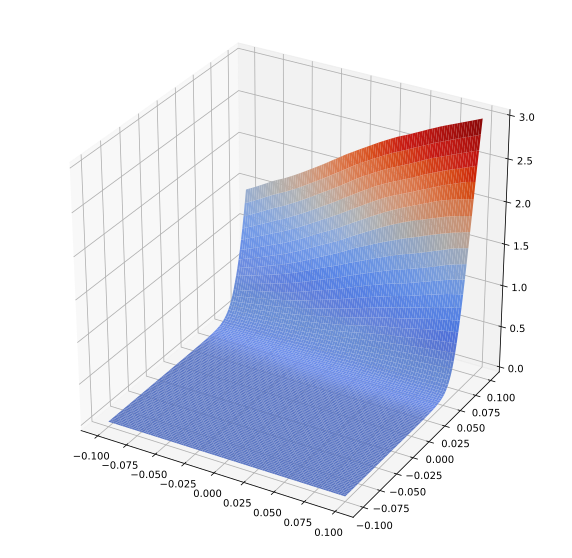

In [ ]:
draw_loss(model_cnn, X[0:1], 0.1)

Very quickly the loss increases substantially.  Let's then compare this to the robust model.

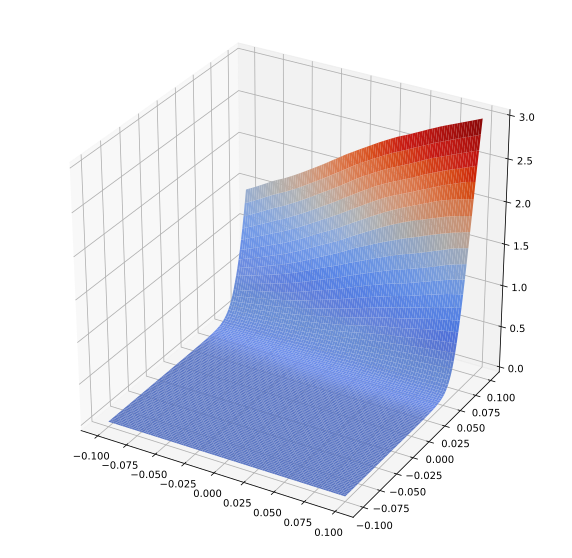

In [ ]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

## Question 5 (hard and almost open question)

Looking at the loss landscape of the robust and the non-robust model, can you provide an explanation of why the models are robust?


answers :

*The robust model has a fairly flat loss in both the gradient direction (i.e., the steepest direction) and the random direction, whereas the traditionally trained model varies fairly rapidly in both the gradient direction and (after moving a bit in the gradient direction) in the random direction. In summary, these models trained using PGD-based adversarial learning appear to be truly robust, in that the underlying models themselves have smooth loss surfaces, and not by some simple "trick" that hides the true direction of cost increase. The question that comes to mind is whether more can be said formally about robustness.*





*Let's use convex bounds (in this case, the interval boundary-based approach) to see what level of adversarial performance we can guarantee for the robust model.*

*Loss surface: standard formation*
*Loss surface: robust training*

*Main conclusion: models that can be verified (convexly) as robust are only a small subset of the truly robust models Convex bounds are usually very loose, unless the model was built with these bounds in mind.*


*Evaluation of robust models:
Our model looks good, but we must be careful in our declaration of success. We need to evaluate it against different attacks, PGD attacks are longer, with random restarts, etc.*
